In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
%matplotlib inline

# Read in Data and Cross Match

In [2]:
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
print(" GAIA Table contains ",len(Gra)," sources")

#calculate distance in pc and proper motion in km/s
Gdist = 1000./Gpar
Gpmra_km = (Gpmra*Gdist*const.au.value)/(u.yr.to('s')*1000.)
Gpmdec_km = (Gpmdec*Gdist*const.au.value)/(u.yr.to('s')*1000.)


#add variables to an array
Gvalues = Gra,Gdec,Gpmra,Gpmdec,Gpar,Gpar_sn,Gdist,Gpmra_km,Gpmdec_km

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#creates list of indentifiers from 2MASS? 

gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [4]:
#read in gould belt YSO catalog

infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
# print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match up GAIA catalog and Gould Belt YSO
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

Read  1442  YSOs from GB YSO catalog
100
(array([ 128,  129,  130,  150,  160,  179,  184,  187,  194,  196,  202,
        212,  253,  258,  265,  279,  281,  282,  309,  347,  348,  349,
        360,  371,  380,  382,  428,  433,  441,  446,  495,  520,  690,
        694,  730,  734,  762,  791,  793,  833,  844,  875,  889,  939,
        942,  961,  962,  964,  974,  975,  978,  979,  982,  987,  992,
       1036, 1042, 1043, 1047, 1059, 1067, 1068, 1093, 1095, 1132, 1133,
       1138, 1145, 1155, 1185, 1213, 1226, 1227, 1233, 1253, 1255, 1258,
       1269, 1276, 1286, 1288, 1292, 1300, 1307, 1312, 1315, 1324, 1326,
       1327, 1330, 1331, 1341, 1345, 1356, 1388, 1402, 1406, 1417, 1420,
       1427]),)


In [5]:
#read in gould belt stars + dust catalgog

infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match up GAIA catalog and Gould Belt stars+dust
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
97
(array([ 690,  744,  749,  850,  891,  893,  949,  989, 1170, 1185, 1213,
       1280, 1291, 1311, 1336, 1400, 1401, 1414, 1437, 1470, 1506, 1583,
       1627, 1721, 1764, 1781, 1793, 1799, 1880, 1907, 1956, 2005, 2079,
       2107, 2178, 2186, 2188, 2194, 2212, 2219, 2223, 2226, 2233, 2254,
       2304, 2330, 2572, 2615, 2642, 2751, 2752, 2859, 2902, 2920, 2956,
       3084, 3119, 3127, 3129, 3133, 3136, 3138, 3170, 3175, 3213, 3267,
       3271, 3287, 3304, 3310, 3326, 3330, 3344, 3346, 3366, 3369, 3372,
       3375, 3380, 3406, 3417, 3435, 3465, 3478, 3480, 3488, 3489, 3494,
       3501, 3512, 3521, 3530, 3542, 3549, 3625, 3697, 3719]),)


In [6]:
#read in c2d YSO catalog 

infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
#print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match up GAIA catalog and c2d YSO catalog
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

Read  262  YSOs from c2d YSO catalog
95
(array([  0,   6,   9,  10,  11,  15,  16,  33,  36,  43,  53,  54,  56,
        57,  59,  61,  63,  64,  67,  70,  72,  77,  78,  79,  81,  85,
        87,  95,  98, 101, 103, 112, 113, 115, 116, 119, 120, 123, 125,
       127, 131, 132, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145,
       159, 162, 172, 174, 175, 179, 182, 184, 186, 187, 189, 195, 197,
       198, 200, 207, 208, 211, 212, 213, 218, 225, 228, 231, 232, 233,
       235, 237, 238, 239, 242, 243, 245, 246, 249, 250, 251, 252, 255,
       256, 257, 259, 261]),)


In [7]:
#read in c2d YSO stars+dust catalog

infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match up GAIA catalog and c2d YSO catalog
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
24
(array([  2,  29,  51,  54, 126, 128, 142, 147, 153, 156, 171, 175, 191,
       193, 201, 214, 217, 219, 223, 224, 228, 235, 238, 251]),)


# Analyze Data

In [10]:
#total number of YSO matches

#YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#All YSO matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

Total number of GAIA matches to YSOs:  195
Total number of GAIA matches to star+dust:  121
Total number of all matches:  316


In [13]:
#Coordinates that indicate regions

#region 1
ra_min1 = 279
ra_max1 = 280.1
dec_min1 = -1
dec_max1 = 1
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#region 2
ra_min2 = 276.5
ra_max2 = 278.5
dec_min2 = -4.25
dec_max2 = -1.75
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#region 3
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -1
dec_max3 = 2
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

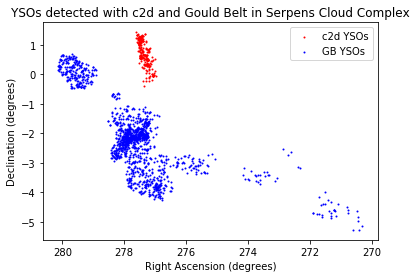

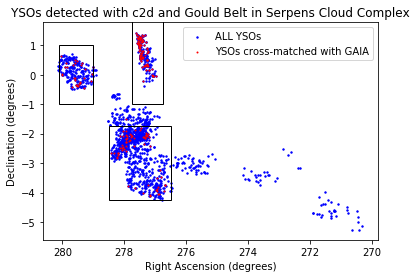

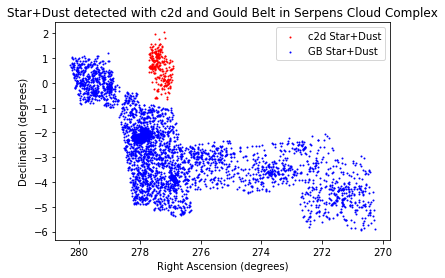

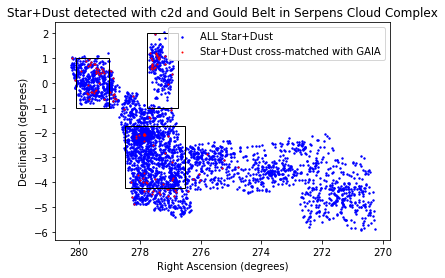

In [14]:
#combine ra and dec for all YSOs into an array for ra and an array for dec
c2dYSOra_data = np.array(c2dYSOra.data)
c2dYSOdec_data = np.array(c2dYSOdec.data)
GBYSOra_data = np.array(GBYSOra.data)
GBYSOdec_data = np.array(GBYSOdec.data)
YSO_ra = c2dYSOra_data; YSO_ra = np.append(YSO_ra,GBYSOra_data)
YSO_dec = c2dYSOdec_data; YSO_dec = np.append(YSO_dec,GBYSOdec_data)

#combine ra and dec for all star+dust into an array for ra and an array for dec
c2dSDra_data = np.array(c2dSDra.data)
c2dSDdec_data = np.array(c2dSDdec.data)
GBSDra_data = np.array(GBSDra.data)
GBSDdec_data = np.array(GBSDdec.data)
SD_ra = c2dSDra_data; SD_ra = np.append(SD_ra,GBSDra_data)
SD_dec = c2dSDdec_data; SD_dec = np.append(SD_dec,GBSDdec_data)

#combine ra and dec for all 


#Plot of c2d and Gould Belt YSOs
figure = plt.figure()
plt.scatter(c2dYSOra_data,c2dYSOdec_data,c='r',label = 'c2d YSOs',s=1)
plt.scatter(GBYSOra_data,GBYSOdec_data,c='b',label = 'GB YSOs',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched YSOs and all YSOs
figure = plt.figure()
plt.scatter(YSO_ra,YSO_dec,c='b',s=2,label='ALL YSOs')
plt.scatter(YSO_ra[YSO_match >-1],YSO_dec[YSO_match >-1],c='r',s=1,label='YSOs cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_plot.png')
plt.show()

#Plot of c2d and Gould Belt star+dust
figure = plt.figure()
plt.scatter(c2dSDra_data,c2dSDdec_data,c='r',label = 'c2d Star+Dust',s=1)
plt.scatter(GBSDra_data,GBSDdec_data,c='b',label = 'GB Star+Dust',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched star+dust and all star+dust
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='ALL Star+Dust')
plt.scatter(SD_ra[SD_match >-1],SD_dec[SD_match >-1],c='r',s=1,label='Star+Dust cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/Star+Dust_plot.png')
plt.show()

#Do the distances need to be filtered? 

In [17]:
#Function to calculate the properties of region of YSOs that have been cross matched with GAIA, 
def CalculateProperties(star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.]):
    
    #create arrays with information about the data
    good_match = match > -1
    ra_match = np.zeros(len(match[good_match]))
    dec_match = np.zeros(len(match[good_match]))
    pmra_match = np.zeros(len(match[good_match]))
    pmdec_match = np.zeros(len(match[good_match]))
    pmra_e_match = np.zeros(len(match[good_match]))
    pmdec_e_match = np.zeros(len(match[good_match]))
    par_match = np.zeros(len(match[good_match]))
    par_sn_match = np.zeros(len(match[good_match]))
    dist_match = np.zeros(len(match[good_match]))
    pmra_km_match = np.zeros(len(match[good_match]))
    pmdec_km_match = np.zeros(len(match[good_match]))
    n = 0
    
    #find number of _match matches in the distance correct interval
    for i in range(0,len(match)):
        if(match[i] > -1):
            j = match[i]
            #Filter values according to distance and region in the sky
            if(Gvalues[6][j] >= distance_range[0] and Gvalues[6][j] <= distance_range[1] \
                and Gvalues[0][j] >= sky_region[0] and Gvalues[1][j] <= sky_region[1] \
                and Gvalues[1][j] >= sky_region[2] and Gvalues[1][j] <= sky_region[3]): 
                    ra_match[n] = Gvalues[0][j]
                    dec_match[n] = Gvalues[1][j]
                    pmra_match[n] = Gvalues[2][j]
                    pmdec_match[n] = Gvalues[3][j]
                    par_match[n] = Gvalues[4][j]
                    par_sn_match[n] = Gvalues[5][j]
                    dist_match[n] = Gvalues[6][j]
                    pmra_km_match[n] = Gvalues[7][j]
                    pmdec_km_match[n] = Gvalues[8][j]
                    n=n+1
    print("Number of "+ star_type +" matches in the correct distance interval:",n)
    
    #find number of match within parallax S/N greater than certain amount
    parsn10 = par_sn_match > 10.
    parsn5 = par_sn_match > 5
    parsn20 = par_sn_match > 20
    print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))

    #scatter plot of ra and dec
    plt.scatter(ra_match[parsn5],dec_match[parsn5],s=5)
    plt.gca().invert_xaxis()
    plt.show()
    #scatter plot of proper motions
    plt.scatter(pmra_km_match[parsn5],pmdec_km_match[parsn5],s=5)
    plt.gca().invert_xaxis()
    plt.show()
    #plot of matches at ra and dec with proper motions
    plt.quiver(ra_match[parsn5],dec_match[parsn5],pmra_km_match[parsn5],pmdec_km_match[parsn5])
    plt.gca().invert_xaxis()
    plt.show()
    
    #mean proper motions
    mean_pmra = np.mean(pmra_match[parsn10])
    mean_pmdec = np.mean(pmdec_match[parsn10])
    print("Mean proper motion (Ra,Dec): ",mean_pmra,mean_pmdec)
    #median proper motions
    median_pmra = np.median(pmra_match[parsn10])
    median_pmdec = np.median(pmdec_match[parsn10])
    print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
    #deviation from median of proper motion  of S/N > 10 _matchs
    rpmra_match = pmra_match - median_pmra
    rpmdec_match = pmdec_match - median_pmdec
    #magnitude of deviation from median of proper motion
    pmmag_match = np.zeros(len(match[good_match]))
    pmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
    
    #calculate standard deviation
    
    #histogram of pmra, pmdec, rpmra, rpmdec
    plt.hist(pmra_match)
    plt.title('Proper Motion (RA)')
    plt.show()
    plt.hist(pmdec_match)
    plt.title('Proper Motion (Dec)')
    plt.show()
    plt.hist(rpmra_match)
    plt.title('Deviation from Median Proper Motion (RA)')
    plt.show()
    plt.hist(rpmdec_match)
    plt.title('Deviation from Median Proper Motion (Dec)')
    plt.show()
    
    #plot of matches at ra and dec with deviation from median of proper motion
    plt.quiver(ra_match[parsn5],dec_match[parsn5],rpmra_match[parsn5],rpmdec_match[parsn5],pmmag_match[parsn5])
    plt.gca().invert_xaxis()
    plt.colorbar()
    plt.show()   
    
    #add all of the calculated values to an array
    result1 = [ra_match, dec_match, pmra_match, pmdec_match, pmra_e_match, pmdec_e_match, \
            par_match, par_sn_match, dist_match, pmra_km_match, pmdec_km_match, \
            rpmra_match,rpmdec_match, pmmag_match,parsn10,parsn5,parsn20]
    result2 = mean_pmra,mean_pmdec,median_pmra,median_pmdec
    
    return result1, result2
            

Number of YSO matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43


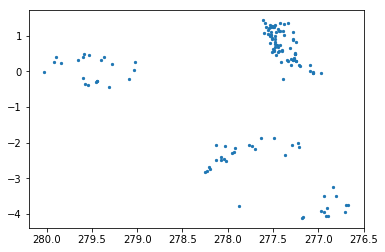

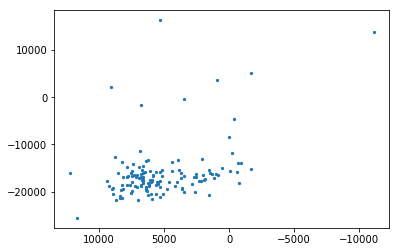

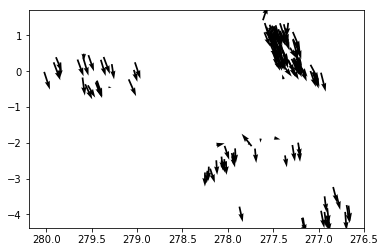

Mean proper motion (Ra,Dec):  2.55007583446 -7.3051741763
Median proper motion (Ra,Dec):  2.94607506771 -8.24536802149


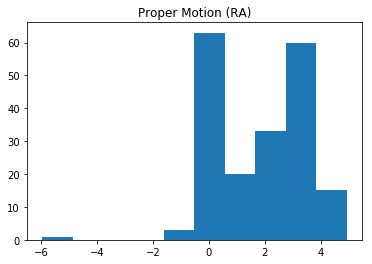

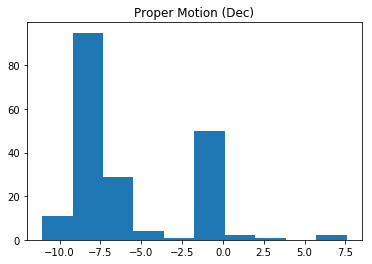

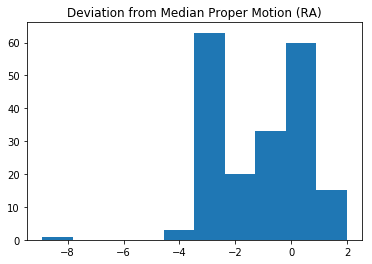

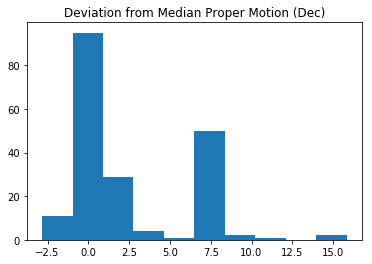

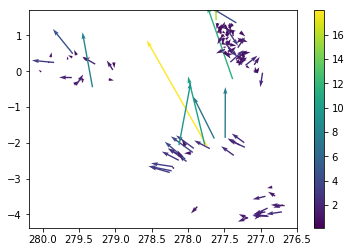

In [18]:
YSO_properties, YSO_values = CalculateProperties('YSO',YSO_match,Gvalues,distance_range=[350.,550.])

raYSO = YSO_properties[0][:]
decYSO = YSO_properties[1][:]
pmraYSO = YSO_properties[2][:]
pmdecYSO = YSO_properties[3][:]
pmra_eYSO = YSO_properties[4][:]
pmdec_eYSO = YSO_properties[5][:]
parYSO = YSO_properties[6][:]
par_snYSO = YSO_properties[7][:]
distYSO = YSO_properties[8][:]
pmra_kmYSO = YSO_properties[9][:]
pmdec_kmYSO = YSO_properties[10][:]
rpmraYSO = YSO_properties[11][:]
rpmdecYSO = YSO_properties[12][:]
pmmagYSO = YSO_properties[13][:]
parsn10YSO = YSO_properties[14][:]
parsn5YSO = YSO_properties[15][:]
parsn10YSO = YSO_properties[16][:]
mean_pmraYSO = YSO_values[0]
mean_pmdecYSO = YSO_values[1]
median_pmraYSO = YSO_values[2]
median_pmdecYSO = YSO_values[3]

Number of Stars+Dust matches in the correct distance interval: 82
Number of _match with parallax > 5, 10, 20:  65 43 26


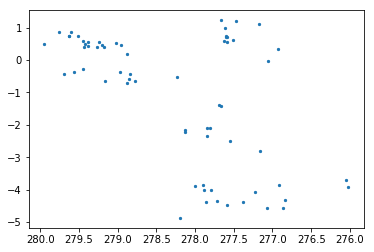

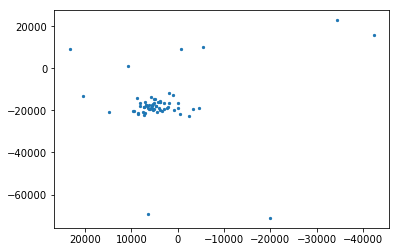

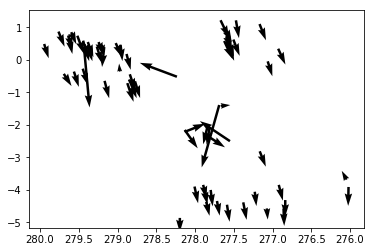

Mean proper motion (Ra,Dec):  1.47433185251 -6.4365700493
Median proper motion (Ra,Dec):  2.20188015497 -8.32510676145


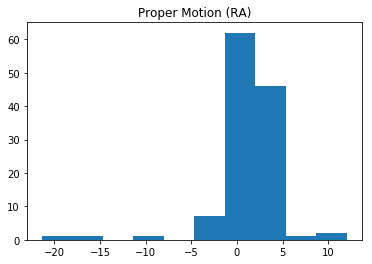

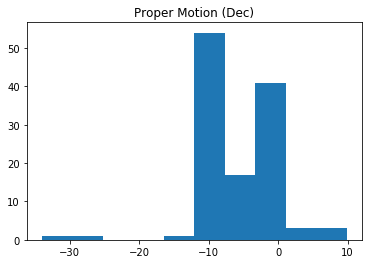

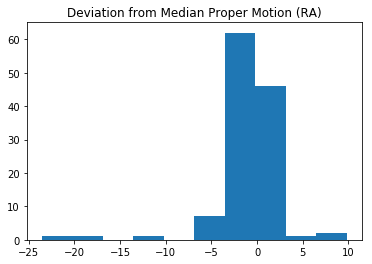

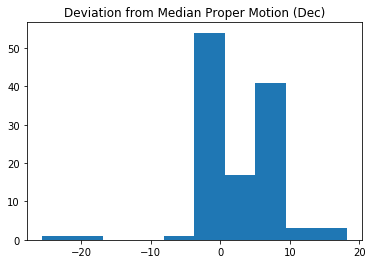

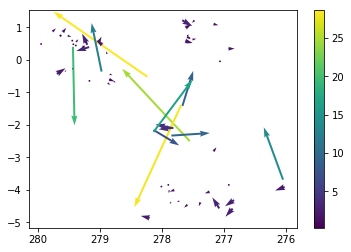

In [19]:
SD_properties, SD_values = CalculateProperties('Stars+Dust',SD_match,Gvalues,distance_range=[350.,550.])

raSD = SD_properties[0][:]
decSD = SD_properties[1][:]
pmraSD = SD_properties[2][:]
pmdecSD = SD_properties[3][:]
pmra_eSD = SD_properties[4][:]
pmdec_eSD = SD_properties[5][:]
parSD = SD_properties[6][:]
par_snSD = SD_properties[7][:]
distSD = SD_properties[8][:]
pmra_kmSD = SD_properties[9][:]
pmdec_kmSD = SD_properties[10][:]
rpmraSD = SD_properties[11][:]
rpmdecSD = SD_properties[12][:]
pmmagSD = SD_properties[13][:]
parsn10SD = SD_properties[14][:]
parsn5SD = SD_properties[15][:]
parsn10SD = SD_properties[16][:]
mean_pmraSD = SD_values[0]
mean_pmdecSD = SD_values[1]
median_pmraSD = SD_values[2]
median_pmdecSD = SD_values[3]

Number of All matches in the correct distance interval: 229
Number of _match with parallax > 5, 10, 20:  200 129 69


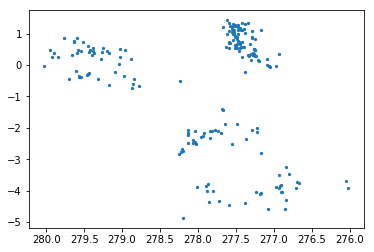

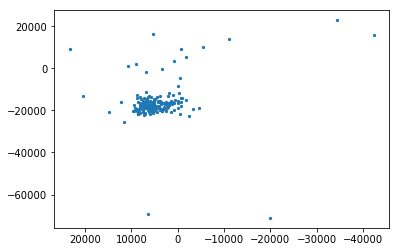

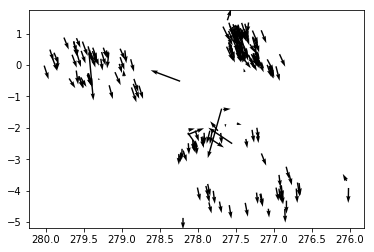

Mean proper motion (Ra,Dec):  2.19149450714 -7.0156394673
Median proper motion (Ra,Dec):  2.74805729747 -8.28196093477


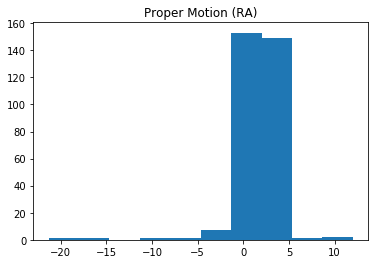

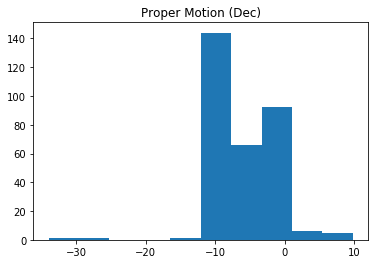

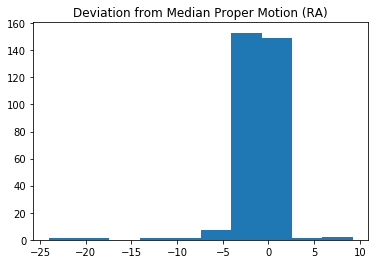

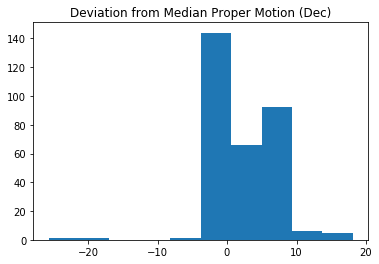

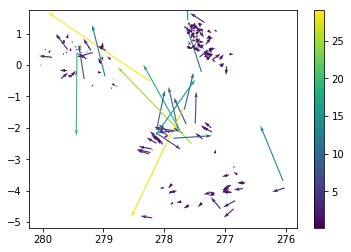

In [20]:
ALL_properties, ALL_values = CalculateProperties('All',ALL_match,Gvalues,distance_range=[350.,550.])

raALL = ALL_properties[0][:]
decALL = ALL_properties[1][:]
pmraALL = ALL_properties[2][:]
pmdecALL = ALL_properties[3][:]
pmra_eALL = ALL_properties[4][:]
pmdec_eALL = ALL_properties[5][:]
parALL = ALL_properties[6][:]
par_snALL = ALL_properties[7][:]
distALL = ALL_properties[8][:]
pmra_kmALL = ALL_properties[9][:]
pmdec_kmALL = ALL_properties[10][:]
rpmraALL = ALL_properties[11][:]
rpmdecALL = ALL_properties[12][:]
pmmagALL = ALL_properties[13][:]
parsn10ALL = ALL_properties[14][:]
parsn5ALL = ALL_properties[15][:]
parsn10ALL = ALL_properties[16][:]
mean_pmraALL = ALL_values[0]
mean_pmdecALL = ALL_values[1]
median_pmraALL = ALL_values[2]
median_pmdecALL = ALL_values[3]

Number of YSO_Reg1 matches in the correct distance interval: 22
Number of _match with parallax > 5, 10, 20:  21 11 6


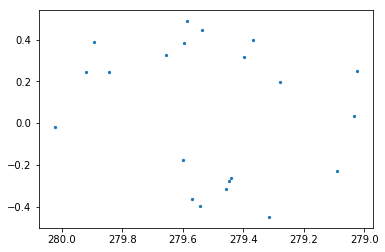

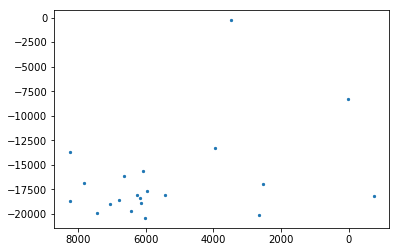

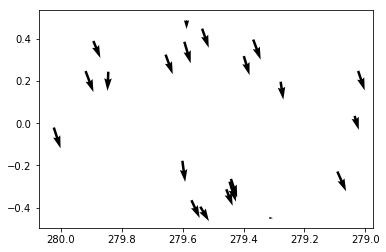

Mean proper motion (Ra,Dec):  2.68584395826 -7.30291361355
Median proper motion (Ra,Dec):  2.74805729747 -7.92417636917


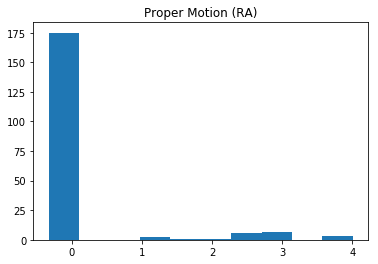

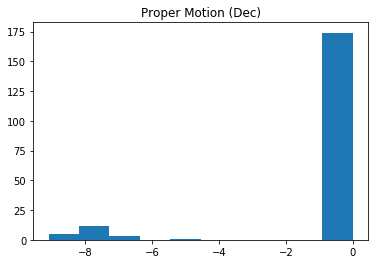

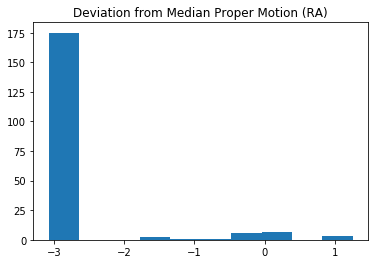

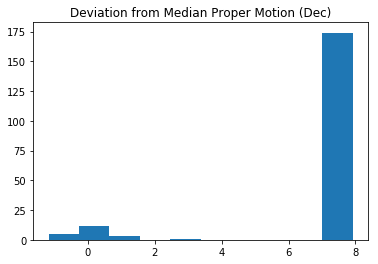

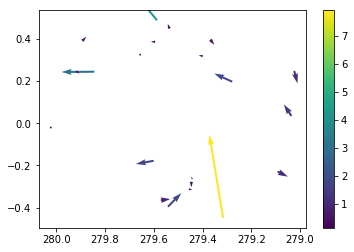

In [21]:
YSO_Reg1_properties, YSO_Reg1_values = CalculateProperties('YSO_Reg1',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min1,ra_max1,dec_min1,dec_max1])

raYSO_Reg1 = YSO_Reg1_properties[0][:]
decYSO_Reg1 = YSO_Reg1_properties[1][:]
pmraYSO_Reg1 = YSO_Reg1_properties[2][:]
pmdecYSO_Reg1 = YSO_Reg1_properties[3][:]
pmra_eYSO_Reg1 = YSO_Reg1_properties[4][:]
pmdec_eYSO_Reg1 = YSO_Reg1_properties[5][:]
parYSO_Reg1 = YSO_Reg1_properties[6][:]
par_snYSO_Reg1 = YSO_Reg1_properties[7][:]
distYSO_Reg1 = YSO_Reg1_properties[8][:]
pmra_kmYSO_Reg1 = YSO_Reg1_properties[9][:]
pmdec_kmYSO_Reg1 = YSO_Reg1_properties[10][:]
rpmraYSO_Reg1 = YSO_Reg1_properties[11][:]
rpmdecYSO_Reg1 = YSO_Reg1_properties[12][:]
pmmagYSO_Reg1 = YSO_Reg1_properties[13][:]
parsn10YSO_Reg1 = YSO_Reg1_properties[14][:]
parsn5YSO_Reg1 = YSO_Reg1_properties[15][:]
parsn10YSO_Reg1 = YSO_Reg1_properties[16][:]
mean_pmraYSO_Reg1 = YSO_Reg1_values[0]
mean_pmdecYSO_Reg1 = YSO_Reg1_values[1]
median_pmraYSO_Reg1 = YSO_Reg1_values[2]
median_pmdecYSO_Reg1 = YSO_Reg1_values[3]

Number of YSO_Reg2 matches in the correct distance interval: 44
Number of _match with parallax > 5, 10, 20:  37 22 14


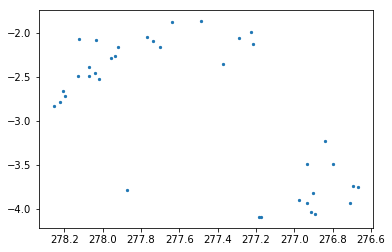

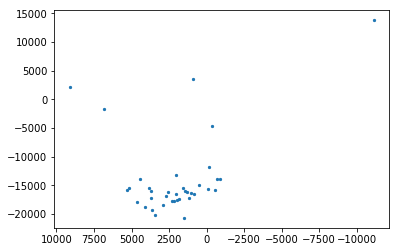

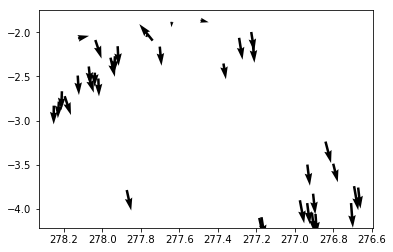

Mean proper motion (Ra,Dec):  1.05960724941 -5.77088266578
Median proper motion (Ra,Dec):  1.0437506861 -7.47994553239


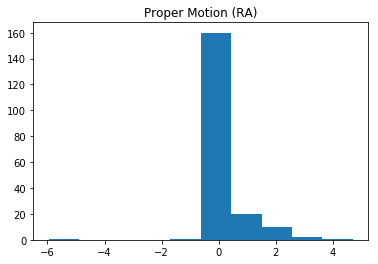

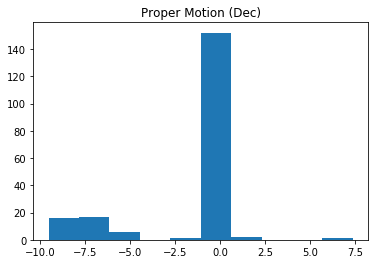

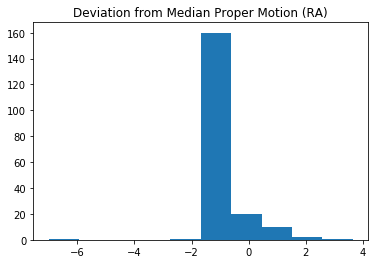

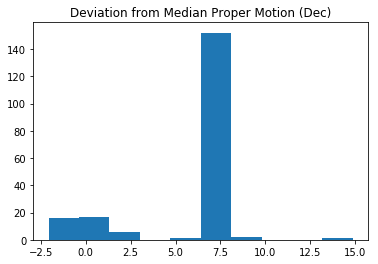

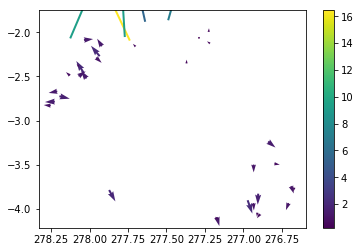

In [22]:
YSO_Reg2_properties, YSO_Reg2_values = CalculateProperties('YSO_Reg2',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min2,ra_max2,dec_min2,dec_max2])

raYSO_Reg2 = YSO_Reg2_properties[0][:]
decYSO_Reg2 = YSO_Reg2_properties[1][:]
pmraYSO_Reg2 = YSO_Reg2_properties[2][:]
pmdecYSO_Reg2 = YSO_Reg2_properties[3][:]
pmra_eYSO_Reg2 = YSO_Reg2_properties[4][:]
pmdec_eYSO_Reg2 = YSO_Reg2_properties[5][:]
parYSO_Reg2 = YSO_Reg2_properties[6][:]
par_snYSO_Reg2 = YSO_Reg2_properties[7][:]
distYSO_Reg2 = YSO_Reg2_properties[8][:]
pmra_kmYSO_Reg2 = YSO_Reg2_properties[9][:]
pmdec_kmYSO_Reg2 = YSO_Reg2_properties[10][:]
rpmraYSO_Reg2 = YSO_Reg2_properties[11][:]
rpmdecYSO_Reg2 = YSO_Reg2_properties[12][:]
pmmagYSO_Reg2 = YSO_Reg2_properties[13][:]
parsn10YSO_Reg2 = YSO_Reg2_properties[14][:]
parsn5YSO_Reg2 = YSO_Reg2_properties[15][:]
parsn10YSO_Reg2 = YSO_Reg2_properties[16][:]
mean_pmraYSO_Reg2 = YSO_Reg2_values[0]
mean_pmdecYSO_Reg2 = YSO_Reg2_values[1]
median_pmraYSO_Reg2 = YSO_Reg2_values[2]
median_pmdecYSO_Reg2 = YSO_Reg2_values[3]

Number of YSO_Reg3 matches in the correct distance interval: 103
Number of _match with parallax > 5, 10, 20:  98 64 29


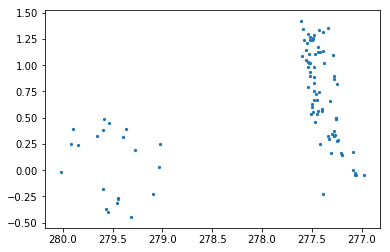

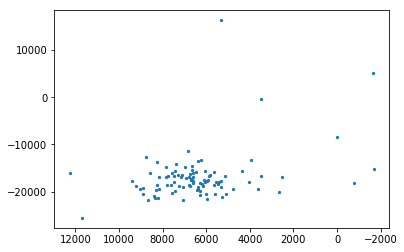

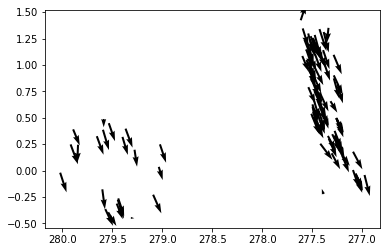

Mean proper motion (Ra,Dec):  3.06242441057 -7.83258688304
Median proper motion (Ra,Dec):  3.16018741376 -8.44770701729


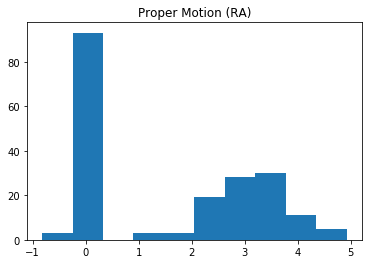

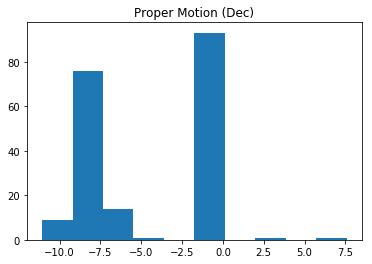

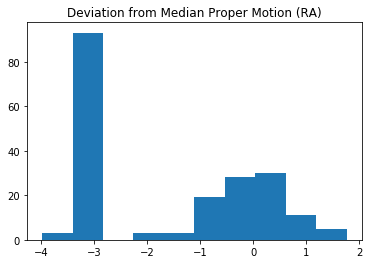

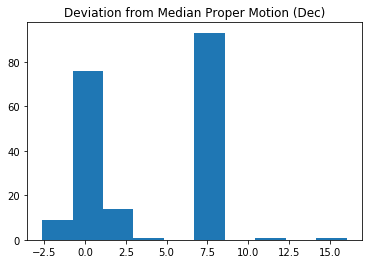

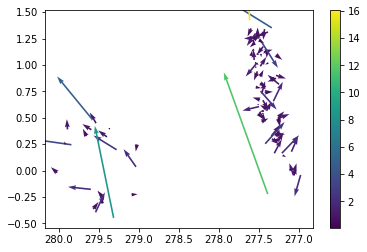

In [23]:
YSO_Reg3_properties, YSO_Reg3_values = CalculateProperties('YSO_Reg3',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min3,ra_max3,dec_min3,dec_max3])

raYSO_Reg3 = YSO_Reg3_properties[0][:]
decYSO_Reg3 = YSO_Reg3_properties[1][:]
pmraYSO_Reg3 = YSO_Reg3_properties[2][:]
pmdecYSO_Reg3 = YSO_Reg3_properties[3][:]
pmra_eYSO_Reg3 = YSO_Reg3_properties[4][:]
pmdec_eYSO_Reg3 = YSO_Reg3_properties[5][:]
parYSO_Reg3 = YSO_Reg3_properties[6][:]
par_snYSO_Reg3 = YSO_Reg3_properties[7][:]
distYSO_Reg3 = YSO_Reg3_properties[8][:]
pmra_kmYSO_Reg3 = YSO_Reg3_properties[9][:]
pmdec_kmYSO_Reg3 = YSO_Reg3_properties[10][:]
rpmraYSO_Reg3 = YSO_Reg3_properties[11][:]
rpmdecYSO_Reg3 = YSO_Reg3_properties[12][:]
pmmagYSO_Reg3 = YSO_Reg3_properties[13][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[14][:]
parsn5YSO_Reg3 = YSO_Reg3_properties[15][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[16][:]
mean_pmraYSO_Reg3 = YSO_Reg3_values[0]
mean_pmdecYSO_Reg3 = YSO_Reg3_values[1]
median_pmraYSO_Reg3 = YSO_Reg3_values[2]
median_pmdecYSO_Reg3 = YSO_Reg3_values[3]

In [30]:
#determine high proper motion YSOs 
high_pmYSO = pmmagYSO[parsn5YSO] > 8.
for i in range(0,len(high_pmYSO)):
    if(high_pmYSO[i]):
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i])

279.453790029 -4.79575643825 YSOc_star+dust(IR2) -3.76667603881 10.820689126 11.4575373246
279.453790029 -4.79575643825 YSOc_star+dust(IR2) 0.703297274399 2.74306354307 2.83178824376
279.453790029 -4.79575643825 YSOc -0.869465456387 2.89188610589 3.01976413471
277.332099703 0.300794132453 YSOc_star+dust(IR2) -2.80033359482 -0.436740417832 2.83418602686
279.453790029 -4.79575643825 YSOc_star+dust(IR2) -2.62941411494 1.92025486412 3.25594799268
279.453790029 -4.79575643825 YSOc_star+dust(IR4) -0.79875021553 1.52186386729 1.7187412654


In [31]:
#FIXED determine high proper motion YSOs
for i in range(0,len(pmmagYSO)):
    if(pmmagYSO[i] > 8): 
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i],par_snYSO[i])
        #figure out difference between i and j

279.453790029 -4.79575643825 YSOc_star+dust(IR2) -3.76667603881 10.820689126 11.4575373246 52.1638450623
279.453790029 -4.79575643825 YSOc_star+dust(MP1) -0.474765863873 15.8194040945 15.8265267362 83.362991333
279.453790029 -4.79575643825 YSOc_star+dust(IR3) -8.90924898894 15.6353749195 17.9955457383 74.2138214111
279.453790029 -4.79575643825 YSOc_star+dust(MP1) -2.46857193192 10.0882754638 10.3859110922 47.1941757202
277.3889497 1.13825537835 YSOc_PAH-em 1.75052523789 9.33831884282 9.50097560352 30.1823787689
279.453790029 -4.79575643825 YSOc_star+dust(IR3) -1.4867043421 8.13160795946 8.2663981157 40.8754005432
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_star+dust(IR4) -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825

In [32]:
print(len(YSO_match))
print(len(high_pmYSO))

1704
135


61441
Number of sources in distance range: 11867
11867


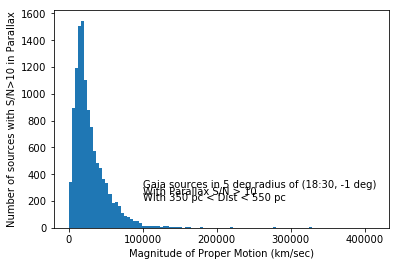

In [21]:
#define variables
ra_big = GTab["ra"]
dec_big = GTab["dec"]
par_big = GTab["parallax"]
pare_big = GTab["parallax_error"]
parsn_big = GTab["parallax_over_error"]
pmra_big = GTab["pmra"]
pmdec_big = GTab["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if (dist > 350. and dist <550. and parsn_big[i]>10.):
        
        pmra_km = (pmra_big[i]*dist*const.au.value)/(secperyr*1000.0)
        pmdec_km = (pmdec_big[i]*dist*const.au.value)/(secperyr*1000.0)
        #pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
        pm2 = pmra_km*pmra_km+pmdec_km*pmdec_km
        pm = np.power(pm2,0.5)
        pm_mag = np.append(pm_mag,pm)
        
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100)
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(100000,300,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(100000,250,"With Parallax S/N > 10")
plt.text(100000,200,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()

# WISE Data

In [ ]:
WISE_YSO = Table.read('WISE_SVM_YSO_class1+2.vot',format='votable')
print(WISE_YSO.colnames)
Wra = WISE_YSO['RAJ2000']
Wdec = WISE_YSO['DEJ2000']

In [51]:
#match up GAIA catalog and WISE YSO catalog
WISE_YSO2MASS = WISE_YSO['_2MASSKey']
WISE_YSO_match = np.empty(len(WISE_YSO2MASS),dtype=int)
WISE_YSO_match.fill(-2)
for j in range(0,len(WISE_YSO2MASS)):
    if(WISE_YSO2MASS[j] in gaia_list):
        WISE_YSO_match[j] = gaia_list.index(WISE_YSO2MASS[j])
    else:
        WISE_YSO_match[j] = -2
good_WISE_YSO = WISE_YSO_match > -1
print(len(WISE_YSO_match[good_WISE_YSO]))
print(np.where(WISE_YSO_match > -1))

0
(array([], dtype=int64),)


In [52]:
#matching the catalogs 

gaia_coord = SkyCoord(ra=Gra,dec=Gdec,unit=(u.deg,u.deg))
WISE_coord = SkyCoord(ra=Wra,dec=Wdec,unit=(u.deg,u.deg))
idx, d2d, d3d = WISE_coord.match_to_catalog_sky(gaia_coord)

In [58]:
#match up GAIA catalog with WISE catalog

for j in range(0,len(WISE_match)):
    if(d3d[i] = np.mean(d3d)):
        WISE_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

<Angle 3.1490453701799347e-06 deg>

In [78]:
WISE_match = np.empty(len(Wra),dtype=int); WISE_match.fill(-2)
for i in range(len(d2d)):
    if (d2d[i] <= Angle('0d00m00.2s')):
        WISE_match[i] = idx[i]
    else:
        WISE_match[i] = -2
good_WISE_YSO = WISE_match >-1
print(len(WISE_match[good_WISE_YSO]))
print(np.where(WISE_match > -1))

76
(array([ 27,  60,  71,  78,  85,  94,  99, 106, 112, 130, 197, 200, 210,
       215, 244, 249, 259, 266, 293, 301, 308, 314, 317, 326, 332, 342,
       505, 513, 514, 515, 522, 540, 541, 546, 547, 550, 559, 564, 567,
       569, 573, 574, 575, 576, 577, 580, 581, 584, 585, 586, 589, 591,
       593, 594, 596, 598, 599, 603, 606, 608, 615, 617, 620, 621, 623,
       627, 634, 641, 643, 645, 646, 650, 654, 656, 661, 669]),)


In [79]:
for i in range(len(c2dYSO_match)):
    if()

array([4003,   -2,   -2,   -2,   -2,   -2, 8680,   -2,   -2,   -2,   -2,
       8671,   -2,   -2,   -2, 4504, 8923,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
       4615,   -2,   -2, 4524,   -2,   -2,   -2,   -2,   -2,   -2, 5090,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2, 4456, 4781,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2, 4547,   -2, 4567,   -2,   -2,   -2,   -2,
         -2, 5132, 5114,   -2, 5855,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2, 5850,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2, 5879,   -2,   -2,   -2,   -2,   -2,   -2, 5744,
         -2,   -2,   -2,   -2, 4872,   -2, 4937,   -2,   -2,   -2,   -2,
       4799,   -2, 5758,   -2, 4947, 5806, 5821, 4866,   -2, 4883, 5752,
         -2, 4939, 4815,   -2,   -2,   -2,   -2,   

In [ ]:
#Failed method to get WISE data

mydec = -1.00
myra = 277.49

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000 #value of new row limit here
Irsa.list_catalogs()
irsatable = Irsa.query_region(SkyCoord(myra,mydec,unit=(u.deg,u.deg),frame='icrs'),catalog='allwise_p3as_psd',\
                              spatial='Box',width=5*u.deg)
print(irsatable['designation','ra','dec','w3mpro','w3sigmpro','id'])